# FBP demo 5 - top-down FDK reconstruction

-----------------------------------------------------------------------------------------------------------------------

<u>*The material provided in this notebook can be freely used and modified for educational purposes only. Please cite any content of the notebook as follows:*</u>

- *Panetta D, Camarlinghi N. 3D Image Reconstruction for CT and PET : A Practical Guide with Python. CRC Press; 2020. Available from: https://www.taylorfrancis.com/books/9780429270239*

*For questions, notifications of bugs, or even just for feedback, please contact the authors directly (daniele.panetta@ifc.cnr.it; niccolo.camarlinghi@gmail.com)*

-----------------------------------------------------------------------------------------------------------------------

### Introduction

This last notebook on FBP reconstruction is a bit more difficult to follow than previous ones, as it goes deeper into implementation details of the Fedlkamp-type reconstruction from pre-computed projection data. The DAPHNE framework will only be used for 3D visualisation in this example. Indeed, some library import is still required and it will be done in the next cell:

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../") # this to be able to include all the object contained in the modules
from Misc.Utils import Unpickle,ReadImage
from Misc.Preview import Visualize3dImage
# set the default size of all the plots 5x5 inches
plt.rcParams['figure.figsize'] = [5, 5]
#from Algorithms.SinogramGenerator import SinogramGenerator
#from Algorithms.FBP import FBP
%matplotlib notebook

### Simple geometry setup

In this example, the geometry is set up at the beginning and it cannot be modified, bacause it must match the geometry used during the generation of the pre-computed projection dataset that will be loaded afterwards. Let us hence define the following geometric parameters used during the reconstruction process:

In [2]:
D = 500            # SAD in mm
Sdd = 750          # SDD in mm
ProjSizeU = 256    # Transversal size of the detector (n. of pixels along the u direction)
ProjSizeV = 256    # Axial size of the detector (n. of pixels along the v direction)
Nang = 360         # N. of gantry angles 
AngStep = 1.0      # Angular step in degrees
VirtDetPitch = 1.421758727602353    # Pitch of the virtual detector in mm (scaled to mag = 1)

### Load projection data from disk

The next cell will be used to load both the phantom data (the reference object) and the pre-computed projection data (the radiographs in the above specified geometry). The object is again the 3D Shepp-Logan head phantom, sampled on a grid size of 256$^3$ cubic voxels. Transposing the data using correct ordering is mandatory for a correct result in the subsequent steps.

<IPython.core.display.Javascript object>


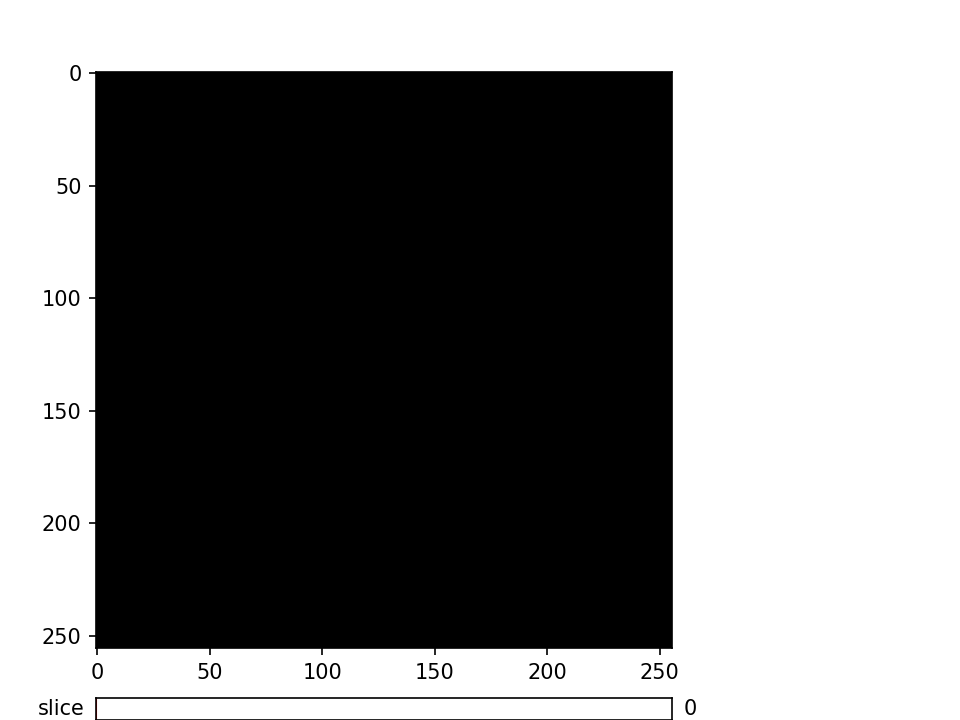

Phantom shape:(256, 256, 256)


<IPython.core.display.Javascript object>


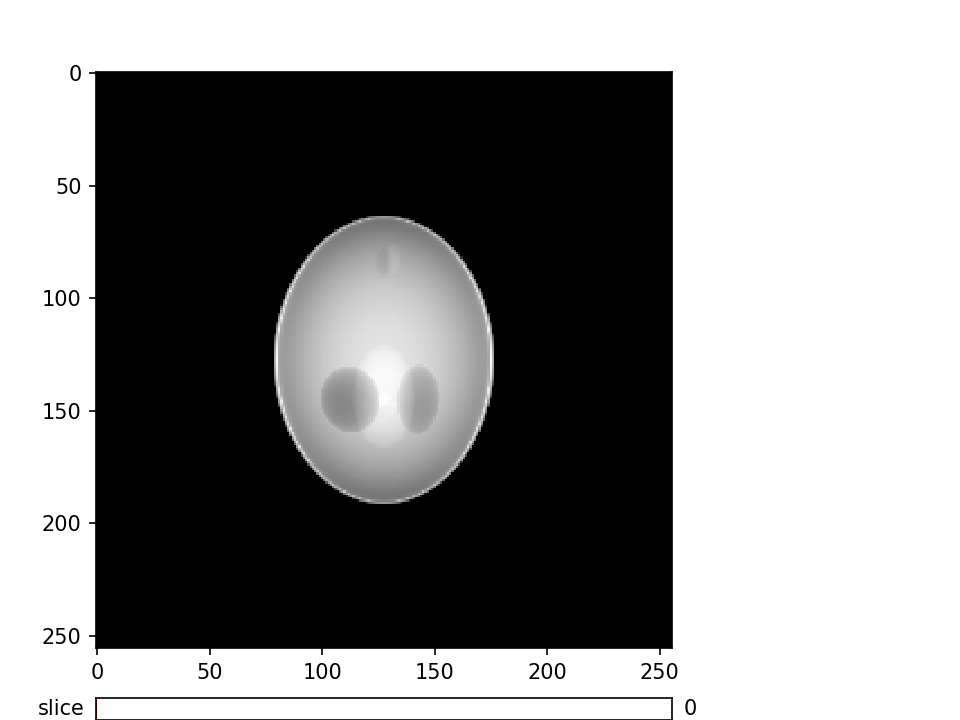

Projection shape:(256, 256, 360)


In [4]:
phantom = np.fromfile("../Data/SL3D_HC_256x256x256.bin", dtype=np.float32).reshape((256,256,256))
phantom = np.transpose(phantom, (1,2,0))
Visualize3dImage(phantom, 2)
print("Phantom shape:" + str(phantom.shape))

projs = np.fromfile("../Data/SL3D_HC_projs_256x256x360.raw", dtype=np.float32).reshape((360,256,256))
projs = np.transpose(projs, (1,2,0))
Visualize3dImage(projs, 2)
print("Projection shape:" + str(projs.shape))


### Generation of ramp filter

As already done in the FBP demo n.3 showing a top-down fan beam reconstruction, we will generate the ramp filter and the weighting factors from stratch. Let us then define the function ```GenerateRempFilterMatrix``` as follows:

In [5]:
def GenerateRampFilterMatrix(nrad, nlines, ncopies):
    h = np.zeros((nrad))
    # find all the indices odd with respect to filter_size/2
    idx = np.arange(1, nrad, 2) + nrad % 2
    h[idx] = -(((idx - nrad // 2) * np.pi) ** 2)
    nnull = h != 0
    # generate the filter impulse response
    h[nnull] = 1 / h[nnull]
    h[nrad // 2] = 1 / 4
    # take the FFT of the filter IR to generate its frequency response
    ramp = np.fft.fft(h)
    H = abs(ramp)
    # this creates a matrix where each column contains H
    # (useful to accelerate the row-by-row multiplication of the sinogram FFT)
    Hm = np.array([H] * nlines)
    Hm = np.transpose(Hm)
    Hm = np.tile(Hm, ncopies).reshape(nrad, nlines, -1)
    return Hm



We can now use the above defined function to generate the 3D array containing all the required copies of the 1D ramp filter, to be used for the frequency-domain filtering of the projection data. In this example, we want to display negative frequencies in their correct position in the graph, i.e., on the left side.

FR(DC) =  0.0007915556440131755
Shape:  (256, 256, 360)


<IPython.core.display.Javascript object>


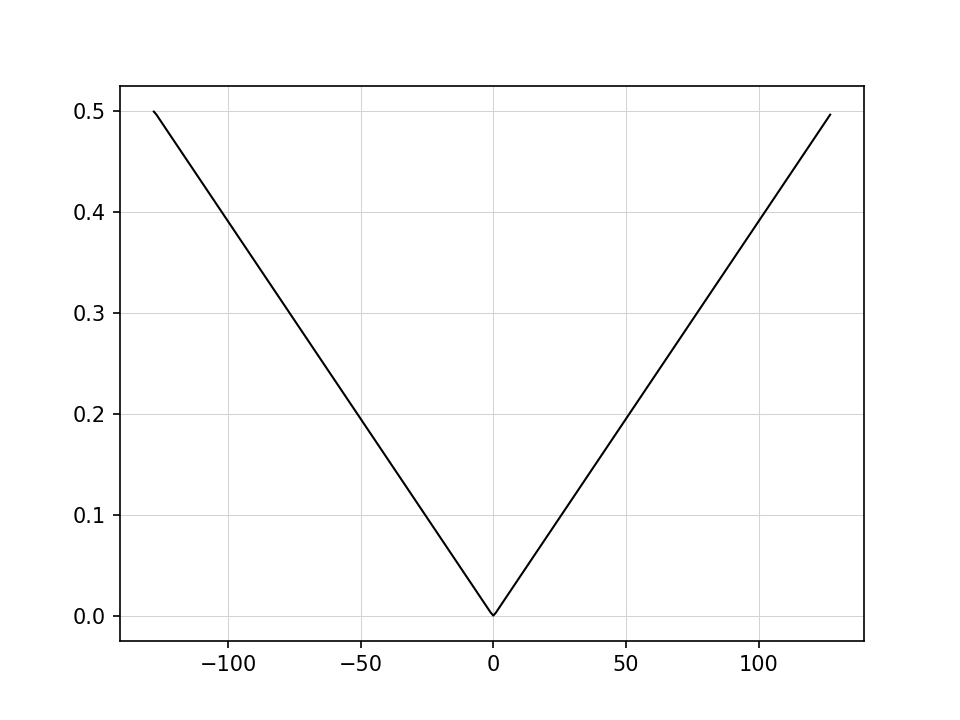

In [6]:
rampFRmatrix = GenerateRampFilterMatrix(ProjSizeU, ProjSizeV, Nang)
print("FR(DC) = ", rampFRmatrix[0,0,0])
print("Shape: ", rampFRmatrix.shape)

plt.figure()
plt.plot(np.linspace(-ProjSizeU/2, ProjSizeU/2-1, ProjSizeU),
         np.fft.fftshift(rampFRmatrix[:,0,0]),
         color ='black', linewidth =1.0 , linestyle ='-')#, marker='+')
plt.grid(which ='both', color ='lightgray', linestyle ='-', linewidth =0.5)


where the ```FR(DC)``` value displayed above was the filter frequency response at DC. This is just to show that this value is slightly different from zero, as it shall be.

### Pre-filter weighting of projection data

As in the fan beam case, we shall now compute and apply the required weighting factors to the projection data prior to apply the ramp filter. Thus, we shall now create a grid of coordinate values of the detector pixels. Let's call these coordinates as ```u_det``` and ```v_det```.

In [7]:
# Create an array with the radial and longitudinal coordinates
# of the 2D detector pixels
u_det,v_det = np.mgrid[-ProjSizeU // 2 + 0.5 : ProjSizeU // 2 + 0.5 : 1,
                             -ProjSizeV // 2 + 0.5 : ProjSizeV // 2 + 0.5 : 1
                            ] * VirtDetPitch
print("Shape of arrays u_det and v_det: " + str(u_det.shape) + ", " + str(v_det.shape))


Shape of arrays u_det and v_det: (256, 256), (256, 256)


The array containing the pre-filter weighting factors, ```w```, is then filled with ```Nang``` copies of the 2D function $w=\frac{D}{\sqrt{D^2+u_{det}^2+v_{det}^2}$.


In [8]:
# Projection weighting factor
w = D / np.sqrt(np.square(D) + np.square(u_det) + np.square(v_det)) 
w = np.repeat(w[:, :, np.newaxis], Nang, axis=2)
print("Shape of array containing weighting factors, w: " + str(w.shape))

Shape of array containing weighting factors, w: (256, 256, 360)


We will now apply the weighting factors to the original projection data. Let us also display the weighting function ```w``` and the difference between the original and weighted projections.

<IPython.core.display.Javascript object>


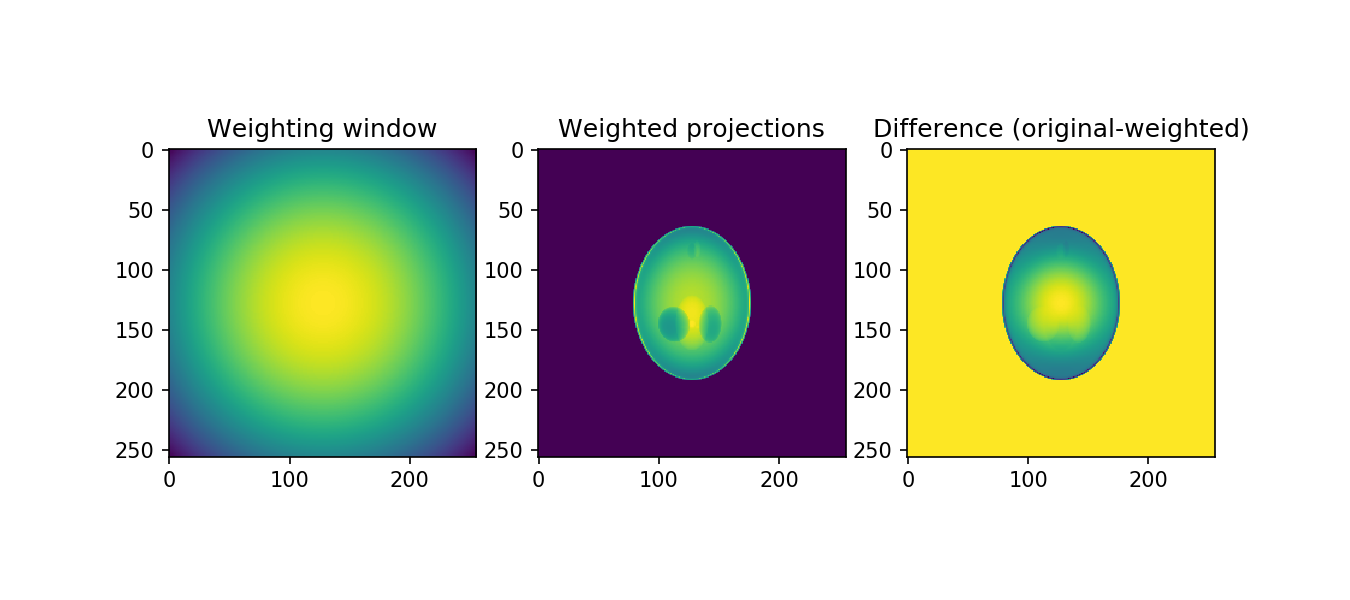

Text(0.5, 1.0, 'Difference (original-weighted)')

In [9]:
# Weight sinogram
weighted_projs = w*projs

plt.figure(figsize=(9,4))
plt.subplot(131)
plt.imshow(w[:,:,0])
plt.title("Weighting window")
plt.subplot(132)
plt.imshow(weighted_projs[:,:,0])
plt.title("Weighted projections")
plt.subplot(133)
plt.imshow(weighted_projs[:,:,0] - projs[:,:,0])
plt.title("Difference (original-weighted)")


### Ramp filtering of projections

This step has the same syntax as in previous examples. We must just be aware of the correct ordering of the input and output arrays, in such a way that the projection data is filtered line-by-line along the radial direction.

In [10]:
fft1d_projs = np.fft.fft(np.rot90(weighted_projs), axis=0)
filtered_projs = np.rot90(np.real(
        np.fft.ifft(fft1d_projs * rampFRmatrix, axis=0)
    ),3)


In the next cell, we will display the original and filtered projection at angle $\beta=0$. Line plots will be created to show the quantitative effect of the ramp filtering.

<IPython.core.display.Javascript object>


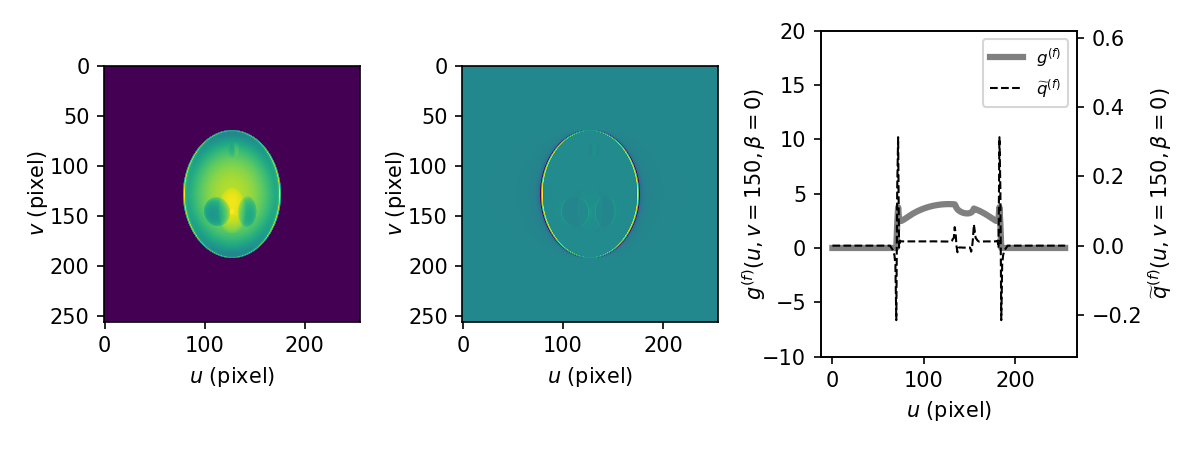

In [11]:
# Subplot 1 - Original sinogram
fig = plt.figure(figsize=(8,3))
plt.subplot("131")
plt.imshow(projs[:,:,0])
#plt.title(r"$g^{f}(u,v)$")
plt.xlabel(r"$u$ (pixel)")
plt.ylabel(r"$v$ (pixel)", labelpad=0)

# Subplot 2 - Filtered sinogram
plt.subplot("132")
plt.imshow(filtered_projs[:,:,0])
#plt.title(r"$\widetilde{q}(x^\prime,\theta)$")
plt.xlabel(r"$u$ (pixel)")
plt.ylabel(r"$v$ (pixel)", labelpad=0)

# Subplot 3 - Line profiles of original and filtered sinograms
vplot = 150
ax1 = plt.subplot("133")
l1 = ax1.plot(projs[:,vplot,0], 
         linewidth=3, color='gray', label=r"$g^{(f)}$")
ax1.set_ylim([-10,20])
ax1.set_xlabel(r"$u$ (pixel)")
ax1.set_ylabel(r"$g^{(f)}(u,v=150, \beta=0$)", 
               labelpad=-3)

ax2 = ax1.twinx()
l2 = ax2.plot(filtered_projs[:,vplot,0], 
         linewidth=1, linestyle='dashed', color='black',
             label=r"$\widetilde{q}^{(f)}$"
             )
ax2.set_ylim([-0.32,0.62])
ax2.set_ylabel(r"$\widetilde{q}^{(f)}(u,v=150, \beta=0$)", 
              labelpad=2
              )

# Create legend
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, prop={'size': 8})

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)


### Cone beam backprojection (single-step)

Now, we are ready to perform a single-view 3D backprojection of the filtered radiographs. As already done in the FBP demo n.3 in fan beam geometry, we will first select a single view from the (filtered) projection data, and we will also create the auxiliary variables needed to compute the weighting factor $W_{BP}$. 

In [12]:
# Create an array with the gantry angles
beta_deg = np.arange(0, Nang, 1)

# Select an angle of projection from its index
# (let's take id=0, which means beta_deg=0°
# in this example)
id_proj = 10

# This tuple stores the projection (2D array) 
# at the selected angle, and the corresponding
# gantry angle in radians
(fproj, beta_rad) = (filtered_projs[:,:,id_proj].T,
                     np.deg2rad(beta_deg)[id_proj])
print("Shape of array containing filtered projections: " + str(fproj.shape))


# Grid of the coordinates of the pixel centers
# in the target image (pitch=1 for simplicity)
Imsize = ProjSizeU
SliceStart = 0
SliceEnd = ProjSizeV
Nslices = SliceEnd-SliceStart

print("Number of slices: " + str(Nslices))

x,y,z = np.mgrid[:Imsize, :Imsize, SliceStart:SliceEnd] - Imsize // 2 + 0.5
y = y*(-1)
r=np.sqrt(np.square(x)+np.square(y))
varphi=np.arctan2(y,x)


# Auxiliary weights for backprojection
U = D + r * np.sin(varphi-beta_rad)
L = np.sqrt(np.square(U)+np.square(r*np.cos(varphi-beta_rad)))
u = r * np.cos(varphi-beta_rad) * D / U
v = z * D / U

# And this is the backprojection weigting factor for the flat detector
#W_BP = np.square(D + x * np.sin(beta_rad) - y * np.cos(beta_rad))
W_BP = np.square(U)

Shape of array containing filtered projections: (256, 256)
Number of slices: 256


Ready? Let us now import the ```RegularGridInterpolator``` function from ```scipy.interpolate```. This function will allow us to perform the bidimensional interpolation (bilinear or bicubic, depending on settings) involved in the cone-beam backprojection. The two 1D arrays ```u_det_1d``` and ```v_det_1d``` stores the $u$ and $v$ coordinates of the detector rows and columns, respectively. They will be used as x and y coordinates in the interpolation function, in the subsequent cell.

In [13]:
from scipy.interpolate import RegularGridInterpolator

u_det_1d = u_det[:,0].reshape(ProjSizeU)
v_det_1d = v_det[0,:].reshape(ProjSizeV)

# Create a target image with the selected number of slices
img_partial = np.zeros([Imsize,Imsize,Nslices], dtype=np.float32)
print("Shape of target volume: " + str(img_partial.shape))



Shape of target volume: (256, 256, 256)


We will now define as ```bp``` the interpolator function. The syntax is pretyy much the same of the ```interp1d``` function used in the stacked-2D examples, but it is better suited for 2D interpolation.

In [14]:
# Backproject
bp = RegularGridInterpolator(
    points = (u_det_1d, v_det_1d),
    values = fproj,
    method = 'linear',
    bounds_error = False, 
    fill_value = 0
) 

img_partial += bp((u,v)) / W_BP


Let us now show the reconstructed (partial) volume along the three main planes, transaxial, coronal and sagittal.

<IPython.core.display.Javascript object>


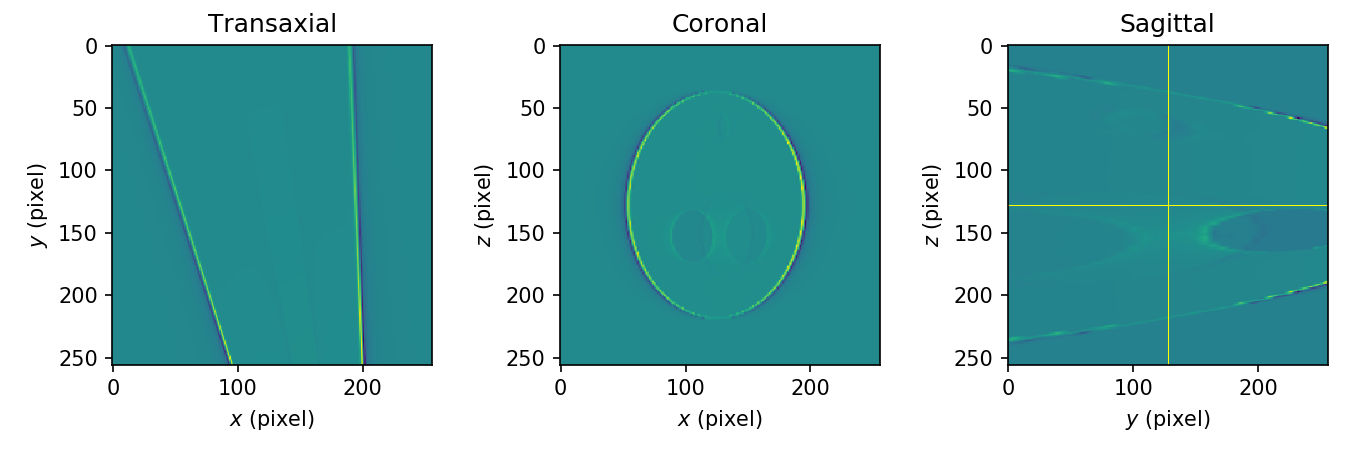

In [15]:
plt.figure(figsize=(9,3))
ax3a = plt.subplot(131)
zplotcoord = Nslices//2
plt.imshow(img_partial[:,:,zplotcoord].T)
ax3a.set_xlabel(r"$x$ (pixel)")
ax3a.set_ylabel(r"$y$ (pixel)")
plt.title("Transaxial")

ax3b = plt.subplot(132)
yplotcoord = Imsize//2
plt.imshow(img_partial[:,yplotcoord,:].T)
ax3b.set_xlabel(r"$x$ (pixel)")
ax3b.set_ylabel(r"$z$ (pixel)")
plt.title("Coronal")

ax3c = plt.subplot(133)
xplotcoord = Imsize//2
plt.axhline(y=zplotcoord, color='yellow', lw=0.5)
plt.axvline(x=yplotcoord, color='yellow', lw=0.5)
plt.imshow(img_partial[xplotcoord,:,:].T)
ax3c.set_xlabel(r"$y$ (pixel)")
ax3c.set_ylabel(r"$z$ (pixel)")
plt.title("Sagittal")

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)


The same partial volume can be inspected interactively by using the ```Visualize3dImage``` in DAPHNE. Just try to play around with axis (but not with array ordering) to inspect the volume along the main planes.

<IPython.core.display.Javascript object>


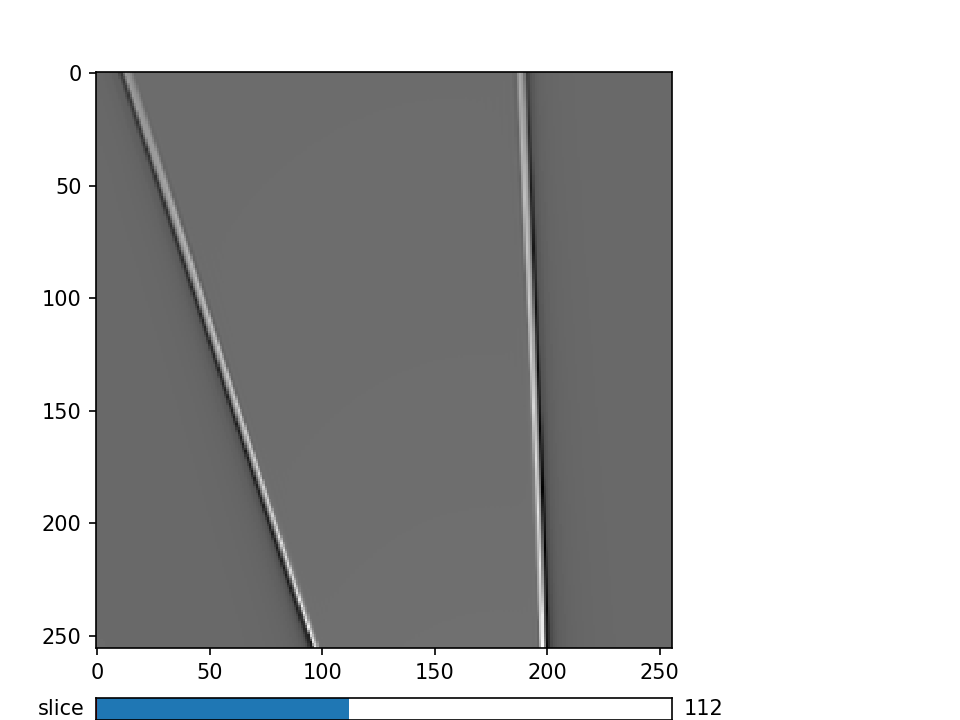

In [17]:
Visualize3dImage(np.transpose(img_partial, (1,0,2)), 2)

### Backprojection (full)

For the full reconstruction, let us select a target volume with a reduced number of slices (40 instead of 256 in this example), just to keep the reconstruction time to be not too long in normal PC's. The reader can then modify the number of slices to see the full 3D reconstruction of the phantom. Of course, all the coordinate grids and weighting factors must be recalculated to cope with the new target volume size.

In [19]:
# Grid of the coordinates of the pixel centers
# in the target image (pitch=1 for simplicity)
Imsize = ProjSizeU
SliceStart = ProjSizeV//2 - 20
SliceEnd = ProjSizeV//2 + 20
Nslices = SliceEnd-SliceStart

print("Number of slices: " + str(Nslices))

x,y,z = np.mgrid[:Imsize, :Imsize, SliceStart:SliceEnd] - Imsize // 2 + 0.5
y = y*(-1)
r=np.sqrt(np.square(x)+np.square(y))
varphi=np.arctan2(y,x)


# Auxiliary weights for backprojection
U = D + r * np.sin(varphi-beta_rad)
L = np.sqrt(np.square(U)+np.square(r*np.cos(varphi-beta_rad)))
u = r * np.cos(varphi-beta_rad) * D / U
v = z * D / U

# And this is the backprojection weigting factor for the flat detector
#W_BP = np.square(D + x * np.sin(beta_rad) - y * np.cos(beta_rad))
W_BP = np.square(U)

Number of slices: 40


To improve recon speed in this example, let us first subsample the projection set angularly by a factor 5. Then, we can define the target image with the correct number of slices and the pairs of projection subset and gantry angle by putting attention to the array ordering required during the reconstructino loop.

In [20]:
# By these three variables, we can control
# the angular range and step in backprojection
ang_subsampling = 5
first_ang = 0
last_ang = 360

# Destination image
img_fdk = np.zeros([Imsize,Imsize,Nslices], dtype=np.float32)

# Define the sets of filtered projections and related grantry angles
fprojs_subset=filtered_projs[:,:,first_ang:last_ang:ang_subsampling].T
angs=np.deg2rad(beta_deg)[first_ang:last_ang:ang_subsampling]

print("Shape of the original array containing the filtered projections: " + str(filtered_projs.shape))
print("Shape of the array sent to the reconstruction loop: " + str(fprojs_subset.shape))


Shape of the original array containing the filtered projections: (256, 256, 360)
Shape of the array sent to the reconstruction loop: (72, 256, 256)


Ready to go. Just run the next cell to reconstruct the full volume.

In [21]:
# Iterate over all the selected projections
i=0
for (fproj, beta_rad) in zip(fprojs_subset, angs):
    i += 1
    print("Backprojecting angle " + str(i) + "/" + str(len(angs)), end="\r")
    U = D + r * np.sin(varphi-beta_rad)
    #L = np.sqrt(np.square(U)+np.square(r*np.cos(varphi-beta_rad)))
    u = r * np.cos(varphi-beta_rad) * D / U
    v = z * D / U
    W_BP = np.square(U)
    
    # Accumulate the weighted values in the destination image
    img_fdk += RegularGridInterpolator(
        points = (u_det_1d, v_det_1d),
        values = fproj,
        method = 'linear',
        bounds_error = False, 
        fill_value = 0
    )  ((u,v)) / W_BP

    

Let's display the volume, first using plain ```matplotlib``` function and then interactively using DAPHNE's ```Visualize3dImage```.

<IPython.core.display.Javascript object>


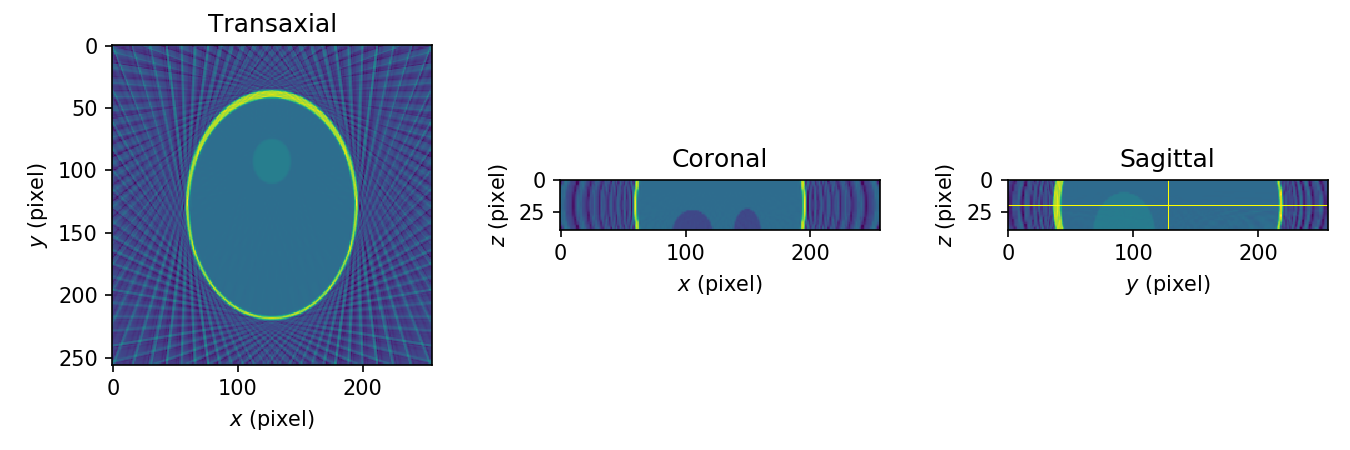

In [22]:
plt.figure(figsize=(9,3))
ax4a = plt.subplot(131)
zplotcoord = Nslices//2
plt.imshow(img_fdk[:,:,zplotcoord].T)
ax4a.set_xlabel(r"$x$ (pixel)")
ax4a.set_ylabel(r"$y$ (pixel)")
plt.title("Transaxial")

ax4b = plt.subplot(132)
yplotcoord = Imsize//2
plt.imshow(img_fdk[:,yplotcoord,:].T)
ax4b.set_xlabel(r"$x$ (pixel)")
ax4b.set_ylabel(r"$z$ (pixel)")
plt.title("Coronal")

ax4c = plt.subplot(133)
xplotcoord = Imsize//2
plt.axhline(y=zplotcoord, color='yellow', lw=0.5)
plt.axvline(x=yplotcoord, color='yellow', lw=0.5)
plt.imshow(img_fdk[xplotcoord,:,:].T)
ax4c.set_xlabel(r"$y$ (pixel)")
ax4c.set_ylabel(r"$z$ (pixel)")
plt.title("Sagittal")

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)


<IPython.core.display.Javascript object>


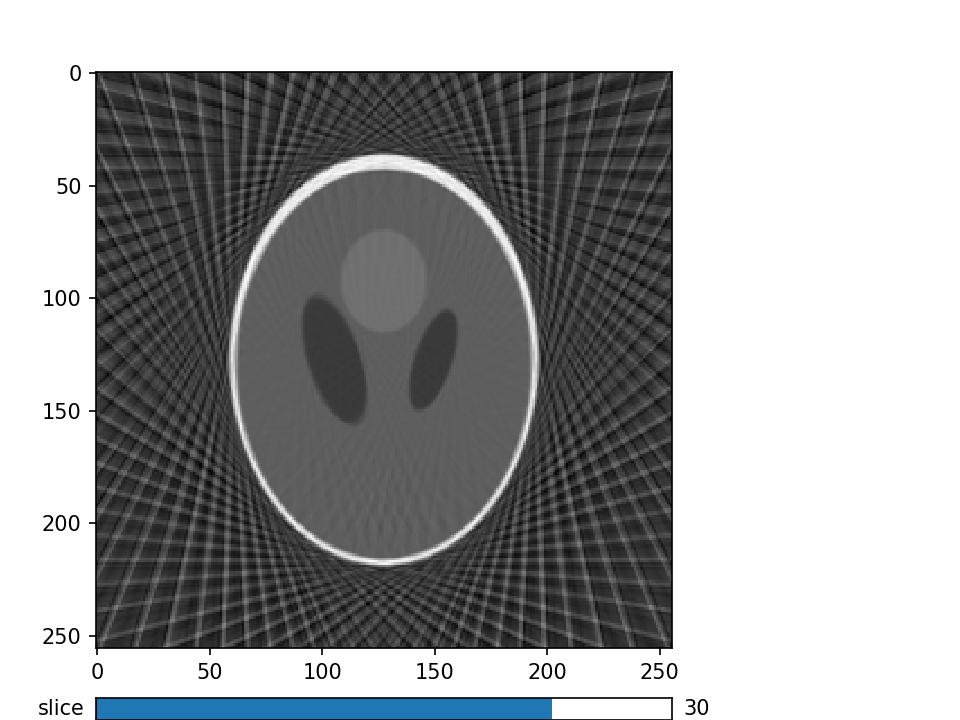

In [23]:
Visualize3dImage(np.transpose(img_fdk, (1,0,2)),2)

Of course, the streak artifacts are caused by the strong angular subsampling used in this example. You can try reducing the ```angular_subsampling``` factor from 5 to 2 (or 1) above, to see how this will reduce streaks in the final image.

### Backprojection (partial)

Similarly to the example in the FBP demo n.3 in fan beam, we will now use auxiliary functions to reconstruct and display partial images in a single line of code. In this case, instead of reconstructing the volume at every angular step of the gantry but in a limited range, we will reconstruct the entire angular range with different angular subsampling.

In [24]:
def PartialConeBeamBP(first_ang_id, last_ang_id, ang_subsampling, projs, dest_img, reset_img=False):

    # Define the sets of filtered projections and related grantry angles
    fprojs_subset=projs[:,:,first_ang_id:last_ang_id:ang_subsampling].T
    angs=np.deg2rad(beta_deg)[first_ang_id:last_ang_id:ang_subsampling]

    if(reset_img==True):
        dest_img.fill(0)
    
    norm = np.pi / Nang
    
    i=0
    print("Reconstructing volume from " + str(len(angs)) + " projections...")
    for (fproj, beta_rad) in zip(fprojs_subset, angs):
        i += 1
        print("Backprojecting angle " + str(i) + "/" + str(len(angs)), end = "\r")
        U = D + r * np.sin(varphi-beta_rad)
        u = r * np.cos(varphi-beta_rad) * D / U
        v = z * D / U
        W_BP = np.square(U)

        # Accumulate the weighted values in the destination image
        dest_img += RegularGridInterpolator(
            points = (u_det_1d, v_det_1d),
            values = fproj,
            method = 'linear',
            bounds_error = False, 
            fill_value = 0
        )  ((u,v)) *norm / W_BP

    print("\ndone")

    
def CreateSubplots(source_img, subplt_nrows, subplt_id_first, subplt_plane_ids, subplt_title, 
                   print_plane_name=False, print_x_axis_title=True, reset_img=False):
    
    if(subplt_plane_ids.ndim != 1 and subplt_plane_ids.shape != np.zeros(3).shape):
        print("Error: subplt_plane_ids must be a vector of three integer numbers")

    # Plot the first plane (transaxial)
    padx = 2
    pady = -10
    plt.subplot(subplt_nrows, 3, subplt_id_first)
    plt.imshow(source_img[:,:,subplt_plane_ids[0]].T, 
                           extent=[x[0,0,0],
                                   x[Imsize-1,0,0],
                                   y[0,0,0],
                                   y[0,Imsize-1,0]
                                  ]
                           )
    if(print_plane_name == True):
        plt.title("transaxial")
    if(print_x_axis_title==True):
        plt.xlabel(r"$x$ (mm)", labelpad = padx)
    plt.ylabel(r"$y$ (mm)", labelpad = pady)

    # Plot the second plane (coronal)
    plt.subplot(subplt_nrows, 3, subplt_id_first+1)
    plt.imshow(source_img[:,subplt_plane_ids[1],:].T,
                           extent=[x[0,0,0],
                                   x[Imsize-1,0,0],
                                   z[0,0,0],
                                   z[0,0,Nslices-1]
                                  ]
                           )
    if(print_plane_name == True):
        plt.title(subplt_title + "\ncoronal")
    else:
        plt.title(subplt_title)
    if(print_x_axis_title==True):
        plt.xlabel(r"$x$ (mm)", labelpad = padx)
    plt.ylabel(r"$z$ (mm)", labelpad = pady)

    # Plot the third plane (sagittal)
    plt.subplot(subplt_nrows, 3, subplt_id_first+2)
    plt.imshow(source_img[subplt_plane_ids[2],:,:].T, 
                           extent=[y[0,0,0],
                                   y[0,Imsize-1,0],
                                   z[0,0,0],
                                   z[0,0,Nslices-1]
                                  ]
                           )
    if(print_plane_name == True):
        plt.title("sagittal")
    if(print_x_axis_title==True):
        plt.xlabel(r"$y$ (mm)", labelpad = padx)
    plt.ylabel(r"$z$ (mm)", labelpad = pady)

Here, we will call the function ```PartialConeBeamBP``` to just reconstruct the partial volumes (four in this case), but we will display them later. This step might take a while to complete (5 to 10 minutes depending on the hardware in use), especially due to the last, full reconstruction without ang subsampling (360 angles). 

In [25]:
# Initialize images
img_fdk_partial1 = np.zeros([Imsize,Imsize,Nslices], dtype=np.float32)
img_fdk_partial2 = np.zeros([Imsize,Imsize,Nslices], dtype=np.float32)
img_fdk_partial3 = np.zeros([Imsize,Imsize,Nslices], dtype=np.float32)
img_fdk_partial4 = np.zeros([Imsize,Imsize,Nslices], dtype=np.float32)

# 1st row: 0-360, step=90
PartialConeBeamBP(0,Nang,90,filtered_projs,img_fdk_partial1,False)
# 2nd row: 0-360, step=45
PartialConeBeamBP(0,Nang,45,filtered_projs,img_fdk_partial2,False)
# 3nd row: 0-360, step=10
PartialConeBeamBP(0,Nang,10,filtered_projs,img_fdk_partial3,False)
# 4th row: 0-360, step=1
PartialConeBeamBP(0,Nang,1,filtered_projs,img_fdk_partial4,False)


Reconstructing volume from 4 projections...
Backprojecting angle 4/4
done
Reconstructing volume from 8 projections...
Backprojecting angle 8/8
done
Reconstructing volume from 36 projections...
Backprojecting angle 36/36
done
Reconstructing volume from 360 projections...
Backprojecting angle 360/360
done


In this cell, we can display the reconstructed volumes by changing few parameters (the displayed planes) without the need to re-run the reconstruction itself.

<IPython.core.display.Javascript object>


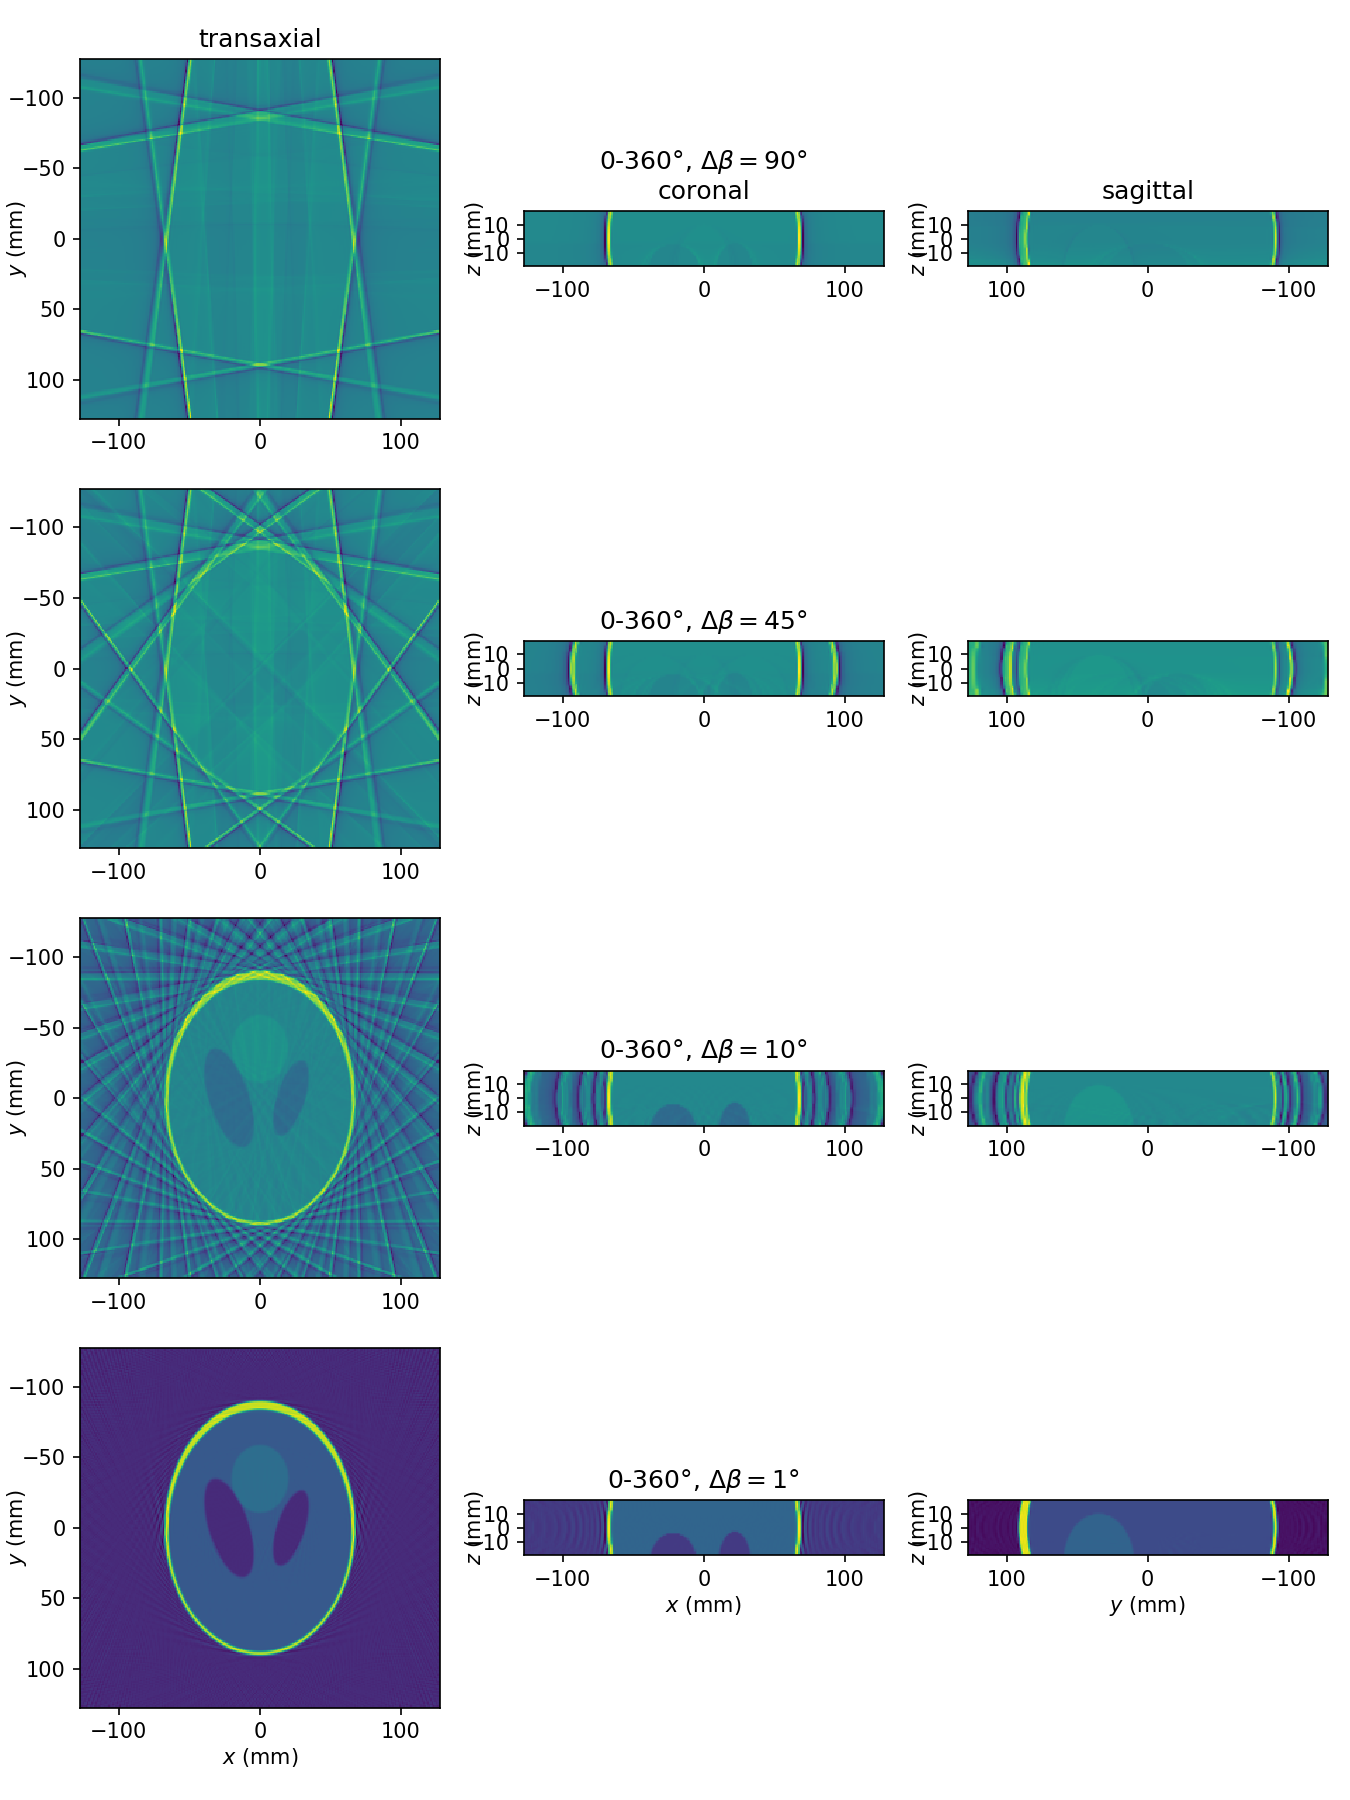

In [26]:
# Initialize plot
plt.figure(figsize=(9,12))

plane_ids = np.array([Nslices//2+15,Imsize//2,Imsize//2])

CreateSubplots(img_fdk_partial1,4,1,plane_ids,r"0-360°, $\Delta\beta=$90°",True,False,False)
CreateSubplots(img_fdk_partial2,4,4,plane_ids,r"0-360°, $\Delta\beta=$45°",False,False,False)
CreateSubplots(img_fdk_partial3,4,7,plane_ids,r"0-360°, $\Delta\beta=$10°",False,False,False)
CreateSubplots(img_fdk_partial4,4,10,plane_ids,r"0-360°, $\Delta\beta=$1°",False,True,False)

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()

#plt.savefig("FDKDemoResult.pdf", bbox_inches='tight', pad_inches=0)

Finally, we can inspect interactively the reconstructed volume without angular subsampling.

<IPython.core.display.Javascript object>


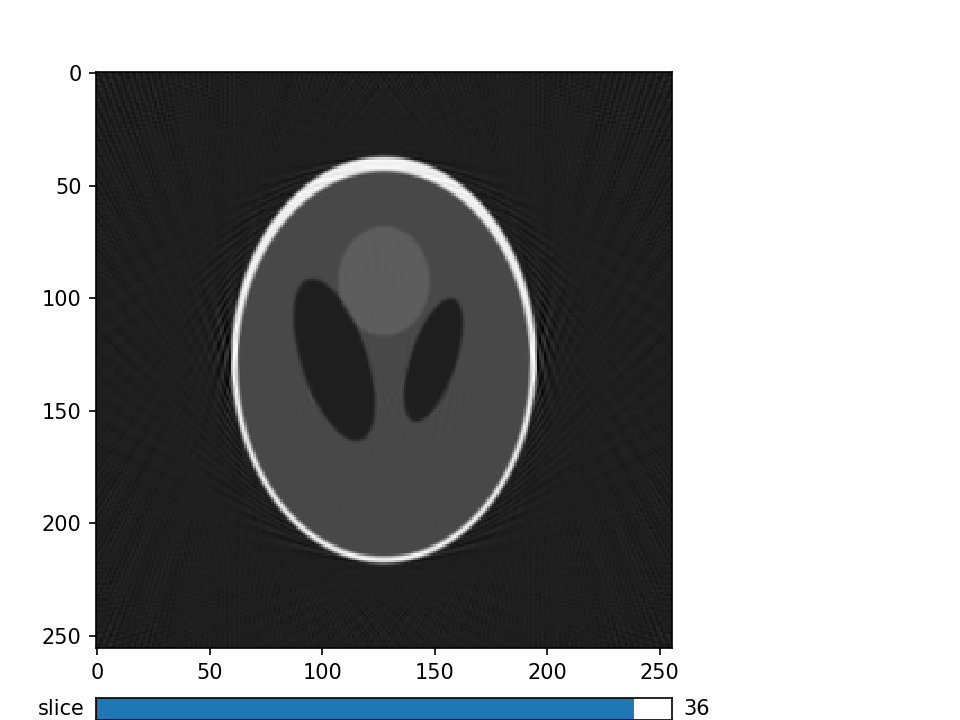

In [27]:
Visualize3dImage(np.transpose(img_fdk_partial4, (1,0,2)), 2)